In [1]:
# importando bibliotecas
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score

import scorecardpy as sc


import statsmodels.api as sm
from scipy import stats
%matplotlib inline

pd.options.display.float_format = '{:.4f}'.format

# pd.options.display.max_columns = None

In [2]:
# Arquivo - original - CSV
fonte = 'C:\\Users\\diego\OneDrive\\Documentos_OneDrive\\Credit_Risk_Modelling\\chap2oneypd.csv'
data_set = pd.read_csv(fonte, sep = ';', header=0, encoding= 'utf-8')

In [3]:
data_set['max_arrears_12m'] = data_set['max_arrears_12m'].round(4)
data_set['arrears_months'] = data_set['arrears_months'].round(4)
data_set['origination_date'] = data_set['origination_date'].str.replace('/','-')

In [4]:
# convertendo campo carregado como objeto para data
data_set['origination_date'] = pd.to_datetime(data_set['origination_date'], dayfirst= True) 

In [5]:
# Criando variável de evento de default
data_set['default_event'] = np.where((data_set['arrears_event' ]== 1) |\
                                      (data_set['term_expiry_event']== 1)|\
                                      (data_set['bankrupt_event']== 1)\
                                        , 1,0)


In [6]:
data_set[['default_event']].to_csv("C:\\Users\\diego\\OneDrive\\Documentos_OneDrive\\LIT_Saint_Paul\\LIT_Analise_Multivariada_de_dados\\defautl_event.csv")

In [51]:
data_set[data_set['bureau_score'].isnull()].head()

,id,vintage_year,monthly_installment,loan_balance,bureau_score,num_bankrupt_iva,time_since_bankrupt,num_ccj,time_since_ccj,ccj_amount,...,avg_mia_6m,max_arrears_bal_6m,max_mia_6m,avg_bal_6m,avg_bureau_score_6m,cc_util,annual_income,emp_length,months_since_recent_cc_delinq,default_event


In [82]:
data_set[['bureau_score','default_event']].query("( bureau_score <= 308) and default_event == 0 ").count()

bureau_score     6161
default_event    6161
dtype: int64

In [84]:
data_set[['bureau_score','default_event']].query("( bureau_score > 404 and bureau_score <= 483) and default_event == 0 ").count()

bureau_score     6169
default_event    6169
dtype: int64

In [85]:
data_set[['bureau_score','default_event']].query("( bureau_score > 483) and default_event == 0 ").count()

bureau_score     6254
default_event    6254
dtype: int64

In [36]:
y = 'default_event'

In [37]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [38]:
iv, woe = iv_woe(data_set[['bureau_score', 'default_event']] , target = 'default_event')

Information value of bureau_score is 0.534308


In [40]:
break_list = {
    'bureau_score': [308, 404, 483],
    'cc_util': [0.55, 0.7, 0.85],
    'num_ccj': [0, 1],
    'max_arrears_12m': [0, 1, 1.4],
    'max_arrears_bal_6m': [0, 300, 600,900],
    'emp_length': [0, 2, 4,7],
    'months_since_recent_cc_delinq': [6,11],
    'annual_income': [35064, 41999, 50111, 65050],
}

In [41]:
{'bureau_score': [308, 404, 483]}

{'bureau_score': [308, 404, 483]}

In [88]:
# 8 Variáveis - Preencher  NAs com zrtos antes da aplicação
bins = sc.woebin(data_set[['default_event','bureau_score']].query("bureau_score > 0"),'default_event', breaks_list={'bureau_score': [0.00000000001,308, 404, 483]})

[INFO] creating woe binning ...


{'bureau_score': <Figure size 432x288 with 2 Axes>}

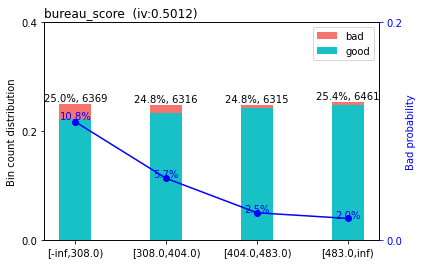

In [89]:
sc.woebin_plot(bins)

In [47]:
bins


{'bureau_score':        variable            bin  count  count_distr  good  bad  badprob  \
 0  bureau_score   [-inf,308.0)   6369       0.2501  5678  691   0.1085   
 1  bureau_score  [308.0,404.0)   6316       0.2481  5959  357   0.0565   
 2  bureau_score  [404.0,483.0)   6315       0.2480  6158  157   0.0249   
 3  bureau_score    [483.0,inf)   6461       0.2538  6334  127   0.0197   
 
       woe  bin_iv  total_iv breaks  is_special_values  
 0  0.7905  0.2241    0.5012  308.0              False  
 1  0.0818  0.0017    0.5012  404.0              False  
 2 -0.7725  0.1061    0.5012  483.0              False  
 3 -1.0128  0.1693    0.5012    inf              False  }

[INFO] creating woe binning ...


{'cc_util': <Figure size 432x288 with 2 Axes>}

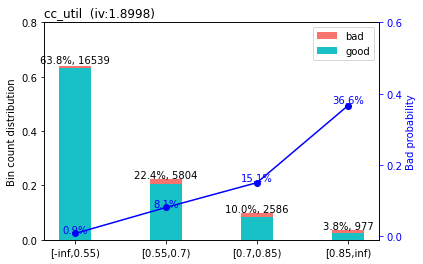

In [25]:
# 8 Variáveis - Preencher  NAs com zrtos antes da aplicação
bins = sc.woebin(data_set[['default_event','cc_util']],'default_event', breaks_list={'cc_util': [0.55, 0.7, 0.85]})
sc.woebin_plot(bins)

[INFO] creating woe binning ...


{'num_ccj': <Figure size 432x288 with 2 Axes>}

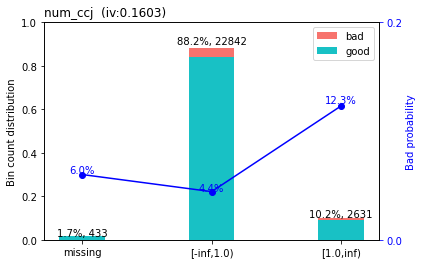

In [18]:
# 8 Variáveis - Preencher  NAs com zrtos antes da aplicação
bins = sc.woebin(data_set[['default_event','num_ccj']],'default_event', breaks_list={'num_ccj': [0, 1]})
sc.woebin_plot(bins)


In [26]:
bins

{'cc_util':   variable          bin  count  count_distr   good  bad  badprob     woe  \
 0  cc_util  [-inf,0.55)  16539       0.6384  16398  141   0.0085 -1.8646   
 1  cc_util   [0.55,0.7)   5804       0.2240   5331  473   0.0815  0.4693   
 2  cc_util   [0.7,0.85)   2586       0.0998   2196  390   0.1508  1.1633   
 3  cc_util   [0.85,inf)    977       0.0377    619  358   0.3664  2.3439   
 
    bin_iv  total_iv breaks  is_special_values  
 0  1.0527    1.8998   0.55              False  
 1  0.0610    1.8998    0.7              False  
 2  0.2290    1.8998   0.85              False  
 3  0.5570    1.8998    inf              False  }

[INFO] creating woe binning ...


{'max_arrears_12m': <Figure size 432x288 with 2 Axes>}

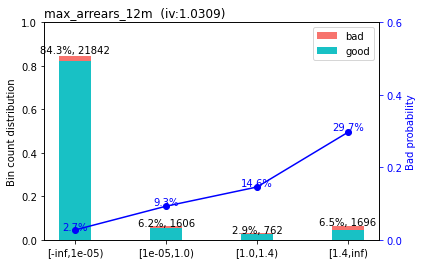

In [31]:
# 8 Variáveis - Preencher  NAs com zrtos antes da aplicação
bins = sc.woebin(data_set[['default_event','max_arrears_12m']],'default_event', breaks_list={'max_arrears_12m': [0.00001, 1, 1.4]})
sc.woebin_plot(bins)

In [32]:
bins

{'max_arrears_12m':           variable           bin  count  count_distr   good  bad  badprob  \
 0  max_arrears_12m  [-inf,1e-05)  21842       0.8431  21243  599   0.0274   
 1  max_arrears_12m   [1e-05,1.0)   1606       0.0620   1457  149   0.0928   
 2  max_arrears_12m     [1.0,1.4)    762       0.0294    651  111   0.1457   
 3  max_arrears_12m     [1.4,inf)   1696       0.0655   1193  503   0.2966   
 
       woe  bin_iv  total_iv breaks  is_special_values  
 0 -0.6770  0.2882    1.0309  1e-05              False  
 1  0.6113  0.0306    1.0309    1.0              False  
 2  1.1225  0.0617    1.0309    1.4              False  
 3  2.0279  0.6503    1.0309    inf              False  }

[INFO] creating woe binning ...


{'max_arrears_bal_6m': <Figure size 432x288 with 2 Axes>}

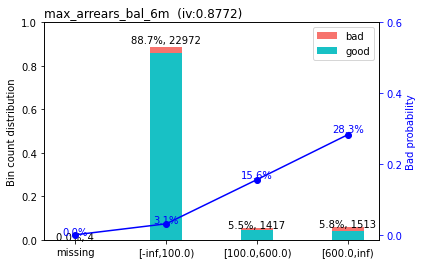

In [20]:
# 8 Variáveis - Preencher  NAs com zrtos antes da aplicação
bins = sc.woebin(data_set[['default_event','max_arrears_bal_6m']],'default_event', breaks_list={'woe_max_arrears_bal_6m': [0, 300, 600,900]})
sc.woebin_plot(bins)


In [ ]:
bins

[INFO] creating woe binning ...


{'emp_length': <Figure size 432x288 with 2 Axes>}

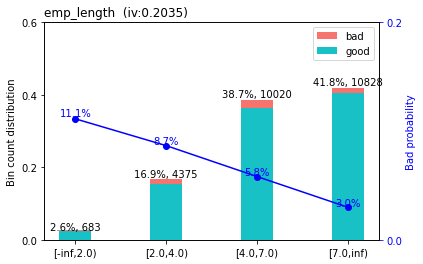

In [21]:
# 8 Variáveis - Preencher  NAs com zrtos antes da aplicação
bins = sc.woebin(data_set[['default_event','emp_length']],'default_event', breaks_list={'emp_length':  [0, 2, 4,7]})
sc.woebin_plot(bins)


In [ ]:
bins

[INFO] creating woe binning ...


{'months_since_recent_cc_delinq': <Figure size 432x288 with 2 Axes>}

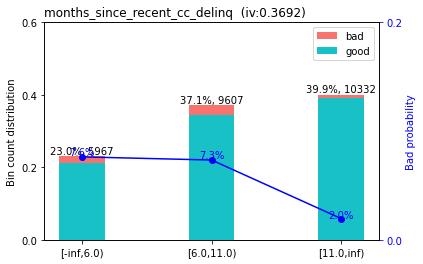

In [22]:
# 8 Variáveis - Preencher  NAs com zrtos antes da aplicação
bins = sc.woebin(data_set[['default_event','months_since_recent_cc_delinq']],'default_event', breaks_list={'months_since_recent_cc_delinq': [6,11]})
sc.woebin_plot(bins)


In [ ]:
bins

[INFO] creating woe binning ...


{'annual_income': <Figure size 432x288 with 2 Axes>}

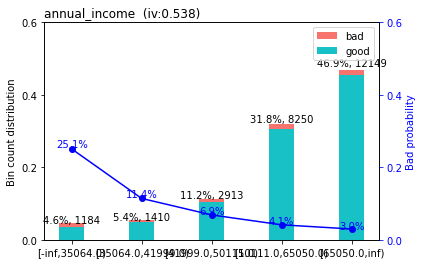

In [23]:
# 8 Variáveis - Preencher  NAs com zrtos antes da aplicação
bins = sc.woebin(data_set[['default_event','annual_income']],'default_event', breaks_list={'annual_income': [35064, 41999, 50111, 65050]})
sc.woebin_plot(bins)


In [ ]:
bins

In [11]:
# Bureau Score - OK
data_set['woe_bureau_score'] = [None]*len(data_set['bureau_score'])
data_set.loc[data_set['bureau_score'].isna(), 'woe_bureau_score'] = -0.0910
data_set.loc[data_set['bureau_score'] <= 308, 'woe_bureau_score'] = -0.7994
data_set.loc[(data_set['bureau_score'] > 308) & (data_set['bureau_score'] <= 404), 'woe_bureau_score'] = -0.0545
data_set.loc[(data_set['bureau_score'] > 404) & (data_set['bureau_score'] <= 483), 'woe_bureau_score'] = 0.7722
data_set.loc[data_set['bureau_score'] > 483, 'woe_bureau_score'] = 1.0375

In [12]:
# CC Util - OK
data_set['woe_cc_util'] = [None]*len(data_set['cc_util'])
data_set.loc[data_set['cc_util'].isna(), 'woe_cc_util'] = 0
data_set.loc[data_set['cc_util'] <= 0.55, 'woe_cc_util'] = 1.8323
data_set.loc[(data_set['cc_util'] > 0.55) & (data_set['cc_util'] <= 0.70), 'woe_cc_util'] = -0.4867
data_set.loc[(data_set['cc_util'] > 0.7) & (data_set['cc_util'] <= 0.85), 'woe_cc_util'] = -1.1623
data_set.loc[data_set['cc_util'] > 0.85, 'woe_cc_util'] = -2.3562


In [13]:
data_set['woe_num_ccj'] = [None]*len(data_set['num_ccj'])
data_set.loc[data_set['num_ccj'].isna(), 'woe_num_ccj'] = -0.0910
data_set.loc[data_set['num_ccj'] <= 0, 'woe_num_ccj'] = -0.1877
data_set.loc[(data_set['num_ccj'] > 0) & (data_set['num_ccj'] <= 1), 'woe_num_ccj'] = -0.9166
data_set.loc[(data_set['num_ccj'] > 1), 'woe_num_ccj'] = -1.1322

In [15]:
# max_arrears_12m - OK
data_set['woe_max_arrears_12m'] = [None]*len(data_set['max_arrears_12m'])
data_set.loc[data_set['max_arrears_12m'].isna(), 'woe_max_arrears_12m'] = 0
data_set.loc[data_set['max_arrears_12m'] <= 0,'woe_max_arrears_12m'] = 0.7027
data_set.loc[(data_set['max_arrears_12m'] > 0) & (data_set['max_arrears_12m'] <= 1), 'woe_max_arrears_12m'] = -0.8291
data_set.loc[(data_set['max_arrears_12m'] > 1) & (data_set['max_arrears_12m'] <= 1.4), 'woe_max_arrears_12m'] = -1.1908
data_set.loc[data_set['max_arrears_12m'] > 1.4, 'woe_max_arrears_12m'] = -2.2223

In [16]:
# max_arrears_bal_6m - OK
data_set['woe_max_arrears_bal_6m'] = [None]*len(data_set['max_arrears_bal_6m'])
data_set.loc[data_set['max_arrears_bal_6m'].isna(), 'woe_max_arrears_bal_6m'] = 0
data_set.loc[data_set['max_arrears_bal_6m'] <= 0, 'woe_max_arrears_bal_6m'] = 0.5771
data_set.loc[(data_set['max_arrears_bal_6m'] > 0) & (data_set['max_arrears_bal_6m'] <= 300), 'woe_max_arrears_bal_6m'] = -0.7818
data_set.loc[(data_set['max_arrears_bal_6m'] > 300) & (data_set['max_arrears_bal_6m'] <= 600), 'woe_max_arrears_bal_6m'] = -1.2958
data_set.loc[(data_set['max_arrears_bal_6m'] > 600) & (data_set['max_arrears_bal_6m'] <= 900), 'woe_max_arrears_bal_6m'] = -1.5753
data_set.loc[data_set['max_arrears_bal_6m'] > 900, 'woe_max_arrears_bal_6m'] = -2.2110


In [17]:
# emp_length - OK
data_set['woe_emp_length'] = [None]*len(data_set['emp_length'])
data_set.loc[data_set['emp_length'].isna(), 'woe_emp_length'] = 0
data_set.loc[data_set['emp_length'] <= 2, 'woe_emp_length'] = -0.7514
data_set.loc[(data_set['emp_length'] > 2) & (data_set['emp_length'] <= 4), 'woe_emp_length'] = -0.3695
data_set.loc[(data_set['emp_length'] > 4) & (data_set['emp_length'] <= 7), 'woe_emp_length'] = 0.1783
data_set.loc[data_set['emp_length'] > 7, 'woe_emp_length'] = 0.5827

In [18]:
# months_since_recent_cc_delinq
data_set['woe_months_since_recent_cc_delinq'] = [None]*len(data_set['months_since_recent_cc_delinq'])
data_set.loc[data_set['months_since_recent_cc_delinq'].isna(), 'woe_months_since_recent_cc_delinq'] = 0
data_set.loc[data_set['months_since_recent_cc_delinq'] < 6, 'woe_months_since_recent_cc_delinq'] = -0.4176
data_set.loc[(data_set['months_since_recent_cc_delinq'] >= 6) & (data_set['months_since_recent_cc_delinq'] <= 11), 'woe_months_since_recent_cc_delinq'] = -0.1942
data_set.loc[data_set['months_since_recent_cc_delinq'] > 11, 'woe_months_since_recent_cc_delinq'] = 1.3166

In [19]:
# annual_income
data_set['woe_annual_income'] = [None]*len(data_set['annual_income'])
data_set.loc[data_set['annual_income'].isna(), 'woe_annual_income'] = 0
data_set.loc[data_set['annual_income'] <= 35064, 'woe_annual_income'] = -1.8243
data_set.loc[(data_set['annual_income'] > 35064) & (data_set['annual_income'] <= 41999), 'woe_annual_income'] = -0.8272
data_set.loc[(data_set['annual_income'] > 41999) & (data_set['annual_income'] <= 50111), 'woe_annual_income'] = -0.3294
data_set.loc[(data_set['annual_income'] > 50111) & (data_set['annual_income'] <= 65050), 'woe_annual_income'] = 0.2379
data_set.loc[data_set['annual_income'] > 65050, 'woe_annual_income'] = 0.6234

In [20]:
# As colunas são criadas como sendo do tipo texto - deve-se converter para float para visualização da matriz de correlação
data_set['woe_bureau_score'] = data_set['woe_bureau_score'].astype(float)
data_set['woe_cc_util'] = data_set['woe_cc_util'].astype(float)
data_set['woe_num_ccj'] = data_set['woe_num_ccj'].astype(float)
data_set['woe_max_arrears_12m'] = data_set['woe_max_arrears_12m'].astype(float)
data_set['woe_max_arrears_bal_6m'] = data_set['woe_max_arrears_bal_6m'].astype(float)
data_set['woe_emp_length'] = data_set['woe_emp_length'].astype(float)
data_set['woe_months_since_recent_cc_delinq'] = data_set['woe_months_since_recent_cc_delinq'].astype(float)
data_set['woe_annual_income'] = data_set['woe_annual_income'].astype(float)

In [21]:
y = data_set['default_event']

In [22]:
x = data_set[['woe_bureau_score',
              'woe_cc_util', 
              'woe_num_ccj',
              'woe_max_arrears_12m',
              'woe_max_arrears_bal_6m',
              'woe_emp_length',
              'woe_months_since_recent_cc_delinq',
              'woe_annual_income',
              ]]

In [23]:
from sklearn.model_selection import train_test_split 
treino, teste = train_test_split(data_set, test_size=0.3, random_state =2122)

In [24]:
# Comando para a divisão entre treino e teste
from sklearn.model_selection import train_test_split 
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.3, random_state =2122)

<AxesSubplot:>

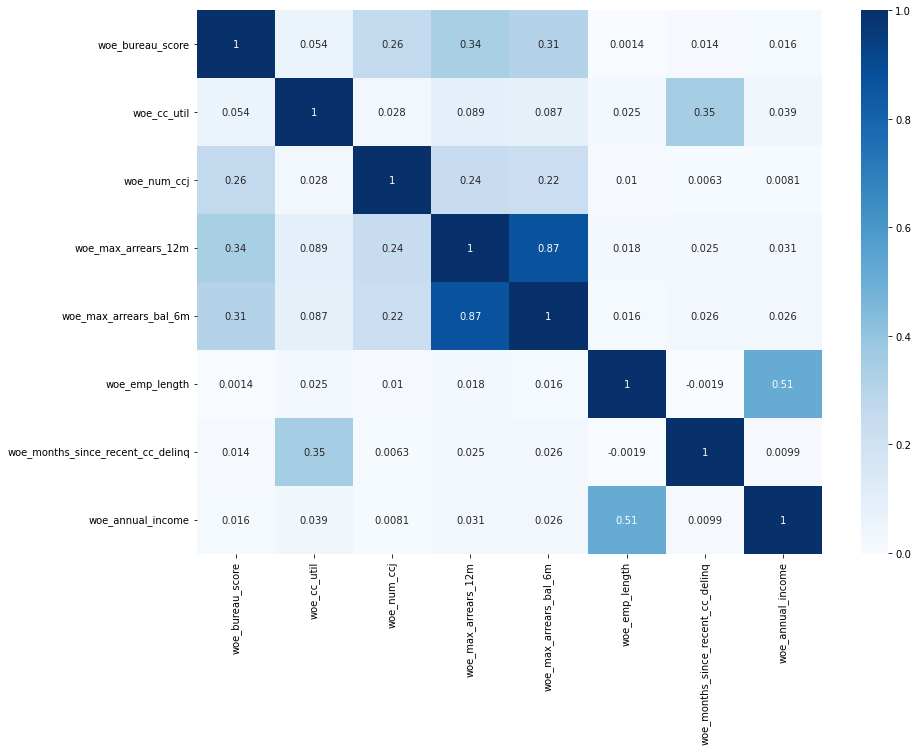

In [25]:
# 15 Variáveis - quais são as relevantes - retirar cor da cevada - roast color
plt.figure(figsize=(14, 10))
sns.heatmap(treino[['woe_bureau_score', 
                      'woe_cc_util', 
                      'woe_num_ccj', 
                      'woe_max_arrears_12m',
                      'woe_max_arrears_bal_6m',
                      'woe_emp_length',
                      'woe_months_since_recent_cc_delinq',
                      'woe_annual_income'
                      ]].corr(method = 'spearman'), cmap = 'Blues', annot= True)

In [26]:
x = data_set[['woe_bureau_score',
              'woe_cc_util', 
              'woe_num_ccj',
              'woe_max_arrears_12m',
              'woe_max_arrears_bal_6m',
              'woe_emp_length',
              'woe_months_since_recent_cc_delinq',
              'woe_annual_income',
              ]]

In [39]:
# Defina as variáveis independentes (X) e a variável dependente (y)
x_logit = x_treino[['woe_bureau_score',
                    'woe_annual_income',
                    'woe_emp_length',
                    'woe_max_arrears_12m',
                    'woe_months_since_recent_cc_delinq',
                    'woe_num_ccj', 
                    'woe_cc_util' ]]

y_logit = y_treino

# Adicione uma coluna de interceptação aos dados
x_logit = sm.add_constant(x_logit)

# Ajuste o modelo de regressão logística
model = sm.GLM(y_logit, x_logit, family=sm.families.Binomial(), method = 'newton')

# Obtenha os resultados do modelo
result = model.fit()

# Imprima um resumo do modelo
print(result.summary())

c:\Users\diego\Anaconda3\lib\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['method']
  warnings.warn(msg, ValueWarning)


                 Generalized Linear Model Regression Results                  
Dep. Variable:          default_event   No. Observations:                18134
Model:                            GLM   Df Residuals:                    18126
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2366.0
Date:                Wed, 31 May 2023   Deviance:                       4732.0
Time:                        10:20:25   Pearson chi2:                 1.70e+04
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1477
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [52]:
y_predict_treino = result.predict(x_treino)

In [53]:
y_predict_teste = result.predict(x_teste)

In [60]:
y_predict_df_treino = pd.DataFrame(y_predict_treino, columns=['predito'])

In [ ]:
y_predict_df_treino['treino'] = 'r'

In [61]:
y_predict_df_teste = pd.DataFrame(y_predict_teste, columns=['predito'])


In [64]:
data_whole = pd.concat([y_predict_df_treino, y_predict_df_teste], axis=0)


In [65]:
data_whole.head(3)

,predito
17395,0.5723
10901,0.3069
8455,0.9500


In [42]:
# TRANSFORMA O RESULTADO DE UMA REGRESSÃO LOGISTICA EM UM SCORE QUE VARIA DE 0 A 10000
def scaled_score(logit, odds, offset=500, pdo=20):
    b = pdo / np.log(2)
    a = offset - b * np.log(odds)
    return np.round(a + b * np.log((1 - logit) / logit))

In [47]:
data_score = pd.concat([x_treino, y_predict_df], axis=1)

In [48]:
np.shape(data_score)

(18134, 9)

In [49]:
data_score.head()

,woe_bureau_score,woe_cc_util,woe_num_ccj,woe_max_arrears_12m,woe_max_arrears_bal_6m,woe_emp_length,woe_months_since_recent_cc_delinq,woe_annual_income,y_predict
17395,-0.7994,1.8323,-0.1877,0.7027,0.5771,0.1783,1.3166,0.6234,0.5723
10901,-0.0545,1.8323,-0.9166,0.7027,0.5771,0.1783,1.3166,0.2379,0.3069
8455,-0.7994,1.8323,-0.1877,0.7027,0.5771,-0.3695,-0.1942,-1.8243,0.9500
11546,1.0375,1.8323,-0.1877,0.7027,0.5771,0.1783,1.3166,0.6234,0.0066
1309,1.0375,1.8323,-0.1877,0.7027,0.5771,0.5827,1.3166,0.6234,0.0058


In [44]:
data_score.columns

Index(['woe_bureau_score', 'woe_cc_util', 'woe_num_ccj', 'woe_max_arrears_12m',
       'woe_max_arrears_bal_6m', 'woe_emp_length',
       'woe_months_since_recent_cc_delinq', 'woe_annual_income', 'y_predict'],
      dtype='object')

In [45]:

data_score['score'] = scaled_score(data_score['y_predict'], 72, 660, 40)

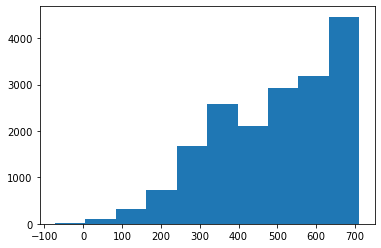

In [46]:
plt.hist(data_score['score'])
plt.show()

In [35]:
# Cria uma função que altera a escala da função logistica
def scaled_score(logit, odds, offset=500, pdo=20):
    b = pdo / np.log(2)
    a = offset - b * np.log(odds)
    return np.round(a + b * np.log((1 - logit) / logit))

# Exemplo de uso
logit_score = 0.8
odds_value = 50

scaled = scaled_score(logit_score, odds_value)
print("Pontuação escalada:", scaled)

Pontuação escalada: 347.0


In [28]:
# Algorítmos para criar os binaries - Método - 01
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer
data_set = data_set[['annual_income', 'default_event']]

# Definir o número desejado de bins
num_bins = 5

# Realizar o binning da variável 'Idade'
age_discretizer = KBinsDiscretizer(n_bins=num_bins, encode='ordinal', strategy='quantile')
data_set['annual_income_binned'] = age_discretizer.fit_transform(data_set[['annual_income']])

# Calcular o WOE para cada categoria de 'Age'
age_woe = data_set.groupby('annual_income_binned')['default_event'].mean() / data_set['default_event'].mean()

# Substituir as categorias pelos valores de WOE
data_set['annual_income_WOE'] = data_set['annual_income_binned'].map(age_woe)

# Verificar o resultado
print(data_set[['annual_income', 'annual_income_binned', 'annual_income_WOE']])

       annual_income  annual_income_binned  annual_income_WOE
0              76749                3.0000             0.5249
1              78451                4.0000             0.6277
2              31038                0.0000             2.3532
3              56663                1.0000             0.8737
4              77014                3.0000             0.5249
...              ...                   ...                ...
25901          56976                1.0000             0.8737
25902          92176                4.0000             0.6277
25903          63121                2.0000             0.6206
25904          41696                0.0000             2.3532
25905          46633                0.0000             2.3532

[25906 rows x 3 columns]


c:\Users\diego\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='annual_income_WOE', ylabel='Density'>

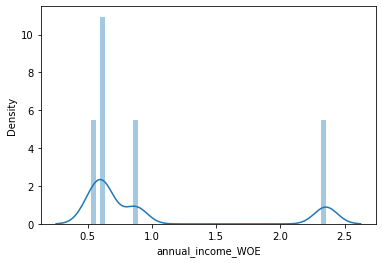

In [29]:
sns.distplot(data_set['annual_income_WOE'])

c:\Users\diego\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='annual_income', ylabel='Density'>

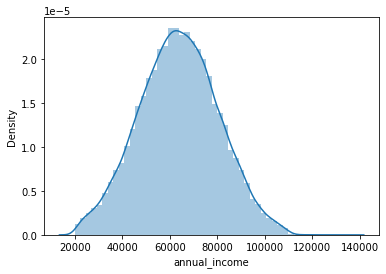

In [30]:
sns.distplot(data_set['annual_income'])

In [22]:
# Método - II
bins = sc.woebin(data_set[['annual_income','default_event']], y="default_event")
bins

[INFO] creating woe binning ...


{'annual_income':         variable                bin  count  count_distr   good  bad  badprob  \
 0  annual_income     [-inf,36000.0)   1329       0.0513   1010  319   0.2400   
 1  annual_income  [36000.0,46000.0)   2517       0.0972   2275  242   0.0961   
 2  annual_income  [46000.0,60000.0)   6859       0.2648   6521  338   0.0493   
 3  annual_income      [60000.0,inf)  15201       0.5868  14738  463   0.0305   
 
       woe  bin_iv  total_iv   breaks  is_special_values  
 0  1.7390  0.3357    0.5405  36000.0              False  
 1  0.6507  0.0553    0.5405  46000.0              False  
 2 -0.0682  0.0012    0.5405  60000.0              False  
 3 -0.5689  0.1482    0.5405      inf              False  }

In [39]:
# breaks_adj = sc.woebin_adj(dt_s, "creditability", bins) 
# # or specify breaks manually
breaks_adj = {
    'annual_income': [36010, 42000, 50000, 60000],
    'other.debtors.or.guarantors': ["none", "co-applicant%,%guarantor"]
}
bins_adj = sc.woebin(data_set[['annual_income','default_event']], y="default_event", breaks_list=breaks_adj)

[INFO] creating woe binning ...


In [40]:
bins_adj

{'annual_income':         variable                bin  count  count_distr   good  bad  badprob  \
 0  annual_income     [-inf,36010.0)   1330       0.0513   1011  319   0.2398   
 1  annual_income  [36010.0,42000.0)   1264       0.0488   1125  139   0.1100   
 2  annual_income  [42000.0,50000.0)   2865       0.1106   2668  197   0.0688   
 3  annual_income  [50000.0,60000.0)   5246       0.2025   5002  244   0.0465   
 4  annual_income      [60000.0,inf)  15201       0.5868  14738  463   0.0305   
 
       woe  bin_iv  total_iv   breaks  is_special_values  
 0  1.7380  0.3355    0.5421  36010.0              False  
 1  0.8004  0.0450    0.5421  42000.0              False  
 2  0.2856  0.0103    0.5421  50000.0              False  
 3 -0.1289  0.0032    0.5421  60000.0              False  
 4 -0.5689  0.1482    0.5421      inf              False  }

In [41]:
# converting train and test into woe values
data_set_woe = sc.woebin_ply(data_set, bins_adj)

[INFO] converting into woe values ...


In [42]:
data_set_woe

,default_event,annual_income_WOE,annual_income_binned,annual_income_woe
0,0,0.5249,3.0000,-0.5689
1,0,0.6277,4.0000,-0.5689
2,1,2.3532,0.0000,1.7380
3,0,0.8737,1.0000,-0.1289
4,0,0.5249,3.0000,-0.5689
...,...,...,...,...
25901,0,0.8737,1.0000,-0.1289
25902,0,0.6277,4.0000,-0.5689
25903,0,0.6206,2.0000,-0.5689
25904,0,2.3532,0.0000,0.8004
